# Fashion MNIST Classification

# Contents <a id='back'></a>

* [1. Initialisation](#init)
* [2. Load the Images](#load)
* [3. Visualise the Images](#visualisation)
* [4. Modeling](#modeling)
* [5. Model Evaluation](#evaluation)

## 1. Initialisation <a id='init'></a>

In [1]:
# Data manipulation
import pandas as pd

# Get the images
from tensorflow.keras.datasets import fashion_mnist

# Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Save the model
import os

In [2]:
# Limit GPU Memory Growth
if tf.test.is_built_with_cuda():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

[Back to Contents](#back)

## 2. Load the images <a id='load'></a>

In [3]:
# Load the images
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# Check the shapes
print('Shape of X_train', X_train.shape)
print('Shape of y_train', y_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_test', y_test.shape)

Shape of X_train (60000, 28, 28)
Shape of y_train (60000,)
Shape of X_test (10000, 28, 28)
Shape of y_test (10000,)


In [5]:
# Get the image shape
img_shape = X_train[0].shape
print('Shape of images:', img_shape)

Shape of images: (28, 28)


In [6]:
# Find the number of classes
num_classes = len(tf.unique(y_train)[0])
print('Number of classes:', num_classes)

Number of classes: 10


In [7]:
# Create class names according to https://keras.io/api/datasets/fashion_mnist/
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Scandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

[Back to Contents](#back)

## 3. Visualise the Images <a id='visualisation'></a>

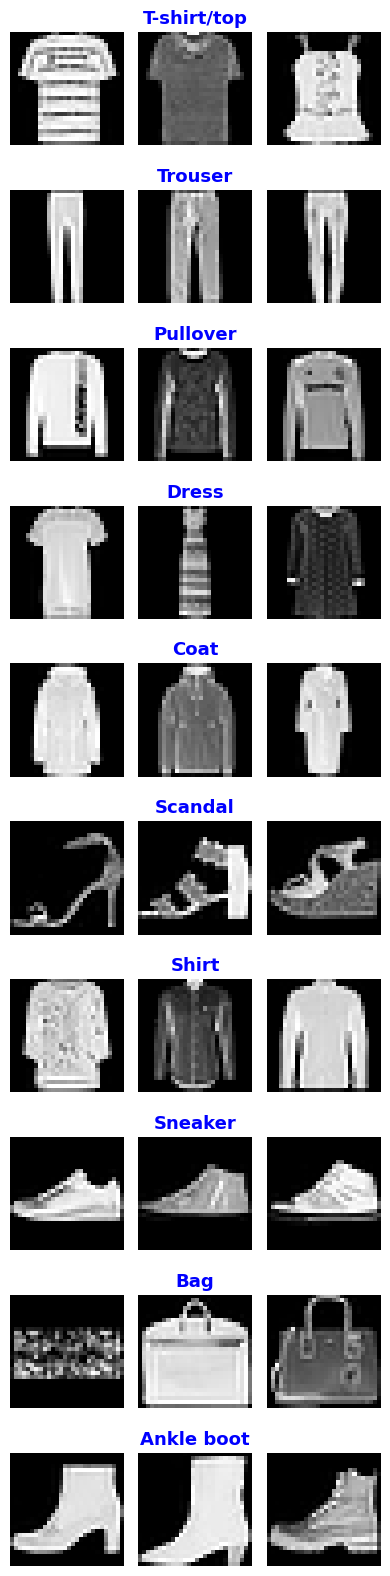

In [8]:
# Have a look at the images
nrows, ncols = num_classes, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(4, 16), sharey=True)

# One class per row
for i in range(nrows):
    # Get the images and labels for the row
    imgs = X_train[y_train == i]
    labels = y_train[y_train == i]
    # Show the images
    for j in range(ncols):
        rand_idx = tf.random.uniform(shape=[], maxval=len(imgs), dtype=tf.int32)
        img = imgs[rand_idx]
        label = labels[rand_idx]

        ax = axs[i][j]
        ax.imshow(img, cmap='gray')
        ax.axis(False)
        if j == 1:
            ax.set_title(class_names[i], fontsize=13, fontweight='bold', color='blue')

plt.tight_layout()
plt.show()

[Back to Contents](#back)

## 4. Modeling <a id='modeling'></a>

Create a function to visualise the losses and accuracy scores of neural network model.

In [9]:
def visualise_loss_accuracy(history, model_name):
    '''
    This function visualise the train and validation losses and accuracies
    '''
    # Set up the figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Figure title
    fig.suptitle(f'Train/Validation Losses and Accuracies of {model_name}', fontsize=14, fontweight='bold', y=1.01)

    # Loss
    ax = axs[0]
    ax.plot(history['loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # MAE
    ax = axs[1]
    ax.plot(history['acc'], label='Train Accuracy')
    ax.plot(history['val_acc'], label='Validation Accuracy')
    ax.set_title('Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.show()

Create a function to store the model and result

In [10]:
def store_model_result(model, history, best_models, result, model_name):
    '''
    This function store the validation accuracy and save the model.
    '''
    result[model_name] = {}
    result[model_name]['val_acc'] = history["val_acc"][-1]
    best_models[model_name] = model
    
    # Delete the model if it exists
    if os.path.isfile(model_path):
        os.remove(model_path)
    
    # Save the model
    best_model[model_name].save(model_path)
    if os.path.isfile(model_path):
        print(f'The {model_name} model has been saved.')

In [11]:
# Datagen for training set
train_datagen = ImageDataGenerator(rescale=1./255)

# Datagen for validation and test sets
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

In [12]:
# Reshap X_train and X_test to fit the datagen
X_train = tf.expand_dims(X_train, -1)
X_test = tf.expand_dims(X_test, -1)

### Model 1 - Basic Neural Network

A basic fully connected network usually does not perform well in computer vision task, let's have a look.

In [13]:
# Dicts to store various information for later use
result = {}
best_model = {}

# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

In [14]:
# Set up for the modeling process
model_name = 'basic_nn'
model_path = os.path.join(model_folder, f'{model_name}.keras')

# Create data generators
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

In [15]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_1 = Sequential()

# Flatten the shape into 28*28=784
model_1.add(Flatten(input_shape=img_shape))

# Add fully connected layer to extracted features
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.4))

# Final layer for prediction
model_1.add(Dense(10, activation='softmax'))

In [16]:
# Compile the model
optimizer = Adam()
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 209514 (818.41 KB)
Trainable params: 20951

In [17]:
%%time
# Train the model
history_1 = model_1.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30


1875/1875 [==============================] - 7s 3ms/step - loss: 0.7368 - acc: 0.7322 - val_loss: 0.5020 - val_acc: 0.8064
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5297 - acc: 0.8159 - val_loss: 0.4420 - val_acc: 0.8386
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4825 - acc: 0.8316 - val_loss: 0.4280 - val_acc: 0.8430
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4625 - acc: 0.8385 - val_loss: 0.4092 - val_acc: 0.8526
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4380 - acc: 0.8441 - val_loss: 0.3892 - val_acc: 0.8540
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4282 - acc: 0.8487 - val_loss: 0.3916 - val_acc: 0.8616
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4198 - acc: 0.8514 - val_loss: 0.3762 - val_acc: 0.8620
Epoch 8/30
1875/1875 [==============================] - 6s 3

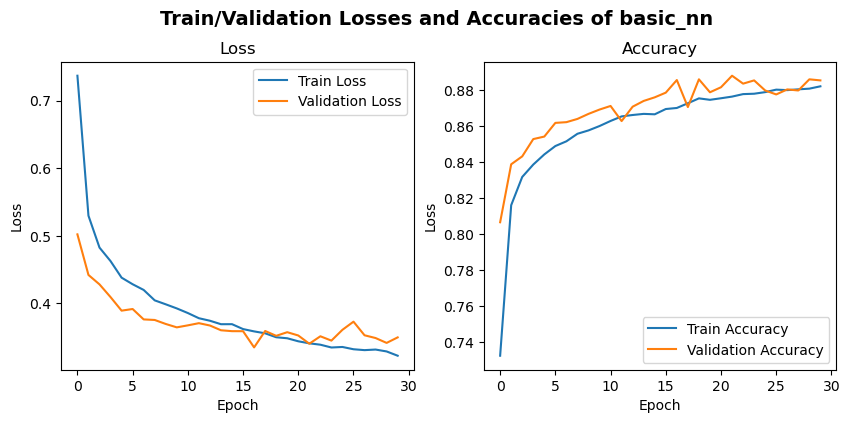

In [18]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_1.history, model_name)

The model has a validation accuracy of 88.52%, let's try a convolution network model.

In [19]:
# Store the validation accuracy and save the model
store_model_result(model_1, history_1.history, best_model, result, model_name)

The basic_nn model has been saved.


### Model 2 - CNN

In [20]:
# Set up for the modeling process
model_name = 'cnn_1'
model_path = os.path.join(model_folder, f'{model_name}.keras')

# Create data generators
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

In [21]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_2 = Sequential()

# Shape for convolution layer
input_shape = img_shape + (1,)

# Add the convolution layers
model_2.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))

# Add the flatten layer
model_2.add(Flatten())

# Add fully connected layer to extracted features
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.3))

# Final layer for prediction
model_2.add(Dense(10, activation='softmax'))

In [22]:
# Compile the model
optimizer = Adam()
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 32)         

In [23]:
%%time
# Train the model
history_2 = model_2.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
1875/1875 [==============================] - 16s 8ms/step - loss: 0.6288 - acc: 0.7745 - val_loss: 0.3942 - val_acc: 0.8560
Epoch 2/30
1875/1875 [==============================] - 15s 8ms/step - loss: 0.4255 - acc: 0.8491 - val_loss: 0.3437 - val_acc: 0.8702
Epoch 3/30
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3736 - acc: 0.8672 - val_loss: 0.2978 - val_acc: 0.8890
Epoch 4/30
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3391 - acc: 0.8796 - val_loss: 0.2935 - val_acc: 0.8932
Epoch 5/30
1875/1875 [==============================] - 14s 8ms/step - loss: 0.3206 - acc: 0.8852 - val_loss: 0.2705 - val_acc: 0.9004
Epoch 6/30
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3050 - acc: 0.8915 - val_loss: 0.2502 - val_acc: 0.9054
Epoch 7/30
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2903 - acc: 0.8965 - val_loss: 0.2442 - val_acc: 0.9110
Epoch 8/30
1875/1875 [==============================] -

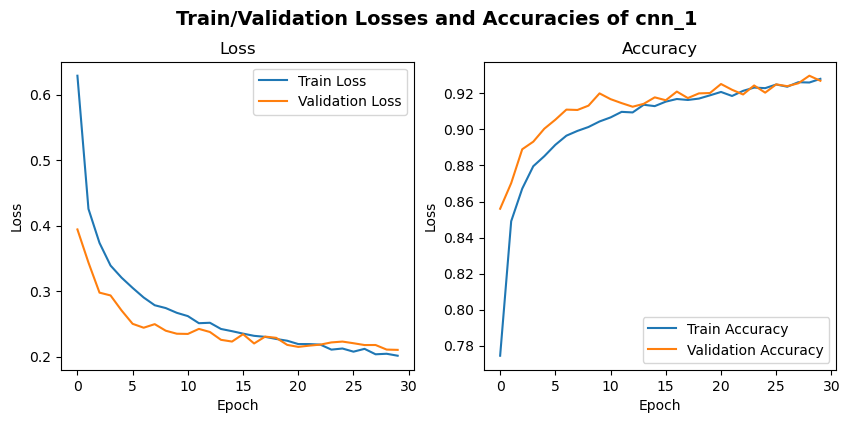

In [24]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_2.history, model_name)

The CNN model has a better validation accuracy of 92.70 compared to the basic neural network.

In [25]:
# Store the validation accuracy and save the model
store_model_result(model_2, history_2.history, best_model, result, model_name)

The cnn_1 model has been saved.


### Model 3 - CNN (Add in batch normalization layers)

Batch normalization layer has the following benefits:
- Improve training stability
- Faster convergence
- Reduce dependency on initialization

Besides that, the batch normalization layer has also a tiny regularization effect. Let's have a look at the performance of the CNN model after adding batch normalization layers.

In [26]:
# Set up for the modeling process
model_name = 'cnn_2'
model_path = os.path.join(model_folder, f'{model_name}.keras')

# Create data generators
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

In [27]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_3 = Sequential()

# Add the convolution layers
model_3.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.2))

# Add the flatten layer
model_3.add(Flatten())

# Add fully connected layer to extracted features
model_3.add(Dense(256, activation='relu'))
model_2.add(BatchNormalization())
model_3.add(Dropout(0.3))
model_3.add(Dense(32, activation='relu'))
model_2.add(BatchNormalization())
model_3.add(Dropout(0.3))

# Final layer for prediction
model_3.add(Dense(10, activation='softmax'))

In [28]:
# Compile the model
optimizer = Adam()
model_3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (Batch  (None, 28, 28, 8)         32        
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        2336      
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 32)       

In [29]:
%%time
# Train the model
history_3 = model_3.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
1875/1875 [==============================] - 18s 9ms/step - loss: 0.6261 - acc: 0.7762 - val_loss: 0.3532 - val_acc: 0.8612
Epoch 2/30
1875/1875 [==============================] - 16s 9ms/step - loss: 0.4067 - acc: 0.8552 - val_loss: 0.3165 - val_acc: 0.8802
Epoch 3/30
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3598 - acc: 0.8724 - val_loss: 0.3057 - val_acc: 0.8882
Epoch 4/30
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3333 - acc: 0.8813 - val_loss: 0.2664 - val_acc: 0.9022
Epoch 5/30
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3138 - acc: 0.8900 - val_loss: 0.2741 - val_acc: 0.9064
Epoch 6/30
1875/1875 [==============================] - 18s 9ms/step - loss: 0.2974 - acc: 0.8952 - val_loss: 0.2440 - val_acc: 0.9144
Epoch 7/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2860 - acc: 0.8982 - val_loss: 0.2706 - val_acc: 0.8964
Epoch 8/30
1875/1875 [==============================] 

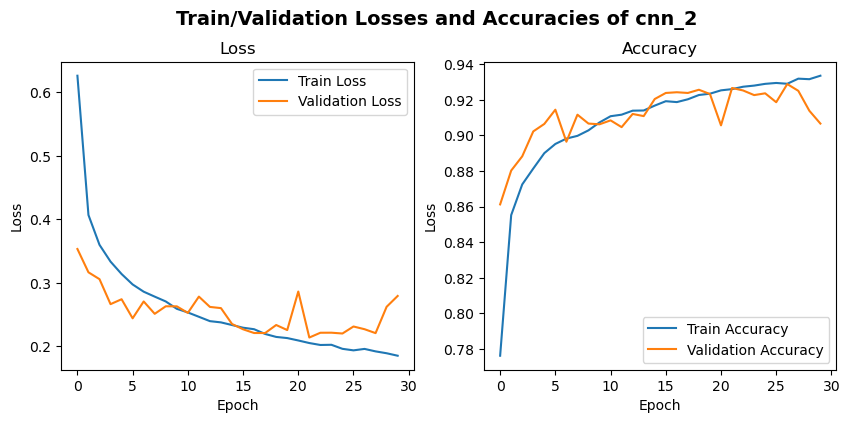

In [30]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_3.history, model_name)

The batch normalization layers does not help the model to perform better in this instance.

In [31]:
# Store the validation accuracy and save the model
store_model_result(model_3, history_3.history, best_model, result, model_name)

The cnn_2 model has been saved.


### Model 4 - CNN (Adjust the Learning Rate, More Epochs)

We will fine tune the learning rate and retrain the model 2 with more epochs.

In [32]:
# Set up for the modeling process
model_name = 'cnn_3'
model_path = os.path.join(model_folder, f'{model_name}.keras')

# Create data generators
train_gen = train_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

In [33]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_4 = Sequential()

# Add the convolution layers
model_4.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.3))

# Add the flatten layer
model_4.add(Flatten())

# Add fully connected layer to extracted features
model_4.add(Dense(256, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))
model_4.add(Dense(32, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))

# Final layer for prediction
model_4.add(Dense(10, activation='softmax'))

In [34]:
# Compile the model
optimizer = Adam()
model_4.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 8)         32        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        2336      
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 32)       

In [35]:
# Define a learning rate scheduler
def lr_schedule_1(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.95

lr_scheduler_1 = LearningRateScheduler(lr_schedule_1)

In [36]:
%%time
# Train the model
history_4 = model_4.fit(train_gen, epochs=60, validation_data=val_gen, callbacks=[lr_scheduler_1])

Epoch 1/60
1875/1875 [==============================] - 20s 10ms/step - loss: 0.6392 - acc: 0.7803 - val_loss: 0.3591 - val_acc: 0.8660 - lr: 0.0010
Epoch 2/60
1875/1875 [==============================] - 18s 9ms/step - loss: 0.4541 - acc: 0.8449 - val_loss: 0.3455 - val_acc: 0.8770 - lr: 0.0010
Epoch 3/60
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4060 - acc: 0.8596 - val_loss: 0.2885 - val_acc: 0.8928 - lr: 0.0010
Epoch 4/60
1875/1875 [==============================] - 18s 9ms/step - loss: 0.3796 - acc: 0.8702 - val_loss: 0.3023 - val_acc: 0.8896 - lr: 0.0010
Epoch 5/60
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3641 - acc: 0.8742 - val_loss: 0.2741 - val_acc: 0.9010 - lr: 0.0010
Epoch 6/60
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3521 - acc: 0.8767 - val_loss: 0.2755 - val_acc: 0.9000 - lr: 0.0010
Epoch 7/60
1875/1875 [==============================] - 18s 9ms/step - loss: 0.3406 - acc: 0.8830 - val_loss

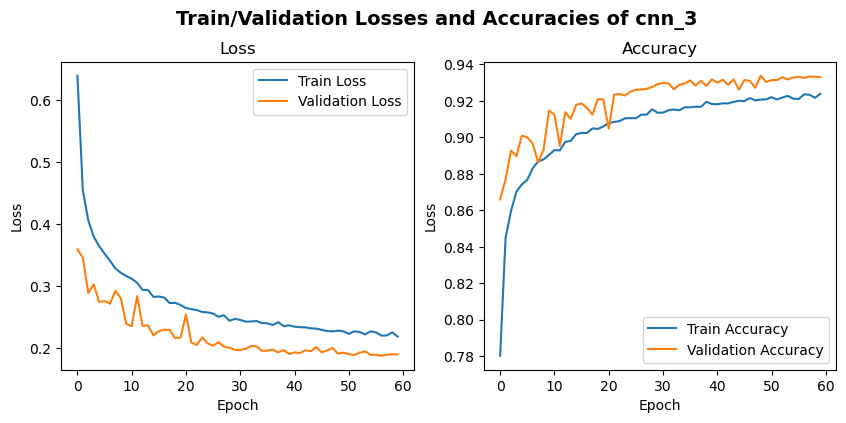

In [37]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_4.history, model_name)

With adjusted learning rate, the model currently has the best validation accuracy. However, there is a mild overfitting issue.

In [38]:
# Store the validation accuracy and save the model
store_model_result(model_4, history_4.history, best_model, result, model_name)

The cnn_3 model has been saved.


### Model 5 - CNN (Data Augmentation)

Data augmentation provides a wider variety of training examples and thus can prevent overfitting and might improve the model performance.

In [39]:
# Datagen for data augmentation
aug_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2)

In [40]:
# Set up for the modeling process
model_name = 'cnn_4'
model_path = os.path.join(model_folder, f'{model_name}.keras')

# Create data generators
train_gen = aug_datagen.flow(X_train, y_train, batch_size=32, seed=42)
val_gen = datagen.flow(X_test, y_test, batch_size=32, subset='training', seed=42)

In [41]:
# For reproducibility
tf.keras.utils.set_random_seed(42)

# Create the model
model_5 = Sequential()

# Add the convolution layers
model_5.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.3))

model_5.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.3))

# Add the flatten layer
model_5.add(Flatten())

# Add fully connected layer to extracted features
model_5.add(Dense(256, activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))
model_5.add(Dense(32, activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.4))

# Final layer for prediction
model_5.add(Dense(10, activation='softmax'))

In [42]:
# Compile the model
optimizer = Adam()
model_5.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

# Have a look at the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_8 (Bat  (None, 28, 28, 8)         32        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        2336      
                                                                 
 batch_normalization_9 (Bat  (None, 14, 14, 32)       

In [43]:
%%time
# Train the model
history_5 = model_5.fit(train_gen, epochs=60, validation_data=val_gen, callbacks=[lr_scheduler_1])

Epoch 1/60
1875/1875 [==============================] - 24s 12ms/step - loss: 0.7481 - acc: 0.7340 - val_loss: 0.4162 - val_acc: 0.8450 - lr: 0.0010
Epoch 2/60
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5573 - acc: 0.8032 - val_loss: 0.3406 - val_acc: 0.8678 - lr: 0.0010
Epoch 3/60
1875/1875 [==============================] - 21s 11ms/step - loss: 0.5071 - acc: 0.8187 - val_loss: 0.3473 - val_acc: 0.8690 - lr: 0.0010
Epoch 4/60
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4795 - acc: 0.8307 - val_loss: 0.3272 - val_acc: 0.8774 - lr: 0.0010
Epoch 5/60
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4630 - acc: 0.8376 - val_loss: 0.3232 - val_acc: 0.8772 - lr: 0.0010
Epoch 6/60
1875/1875 [==============================] - 22s 11ms/step - loss: 0.4473 - acc: 0.8408 - val_loss: 0.2809 - val_acc: 0.8968 - lr: 0.0010
Epoch 7/60
1875/1875 [==============================] - 22s 12ms/step - loss: 0.4385 - acc: 0.8457 - val_l

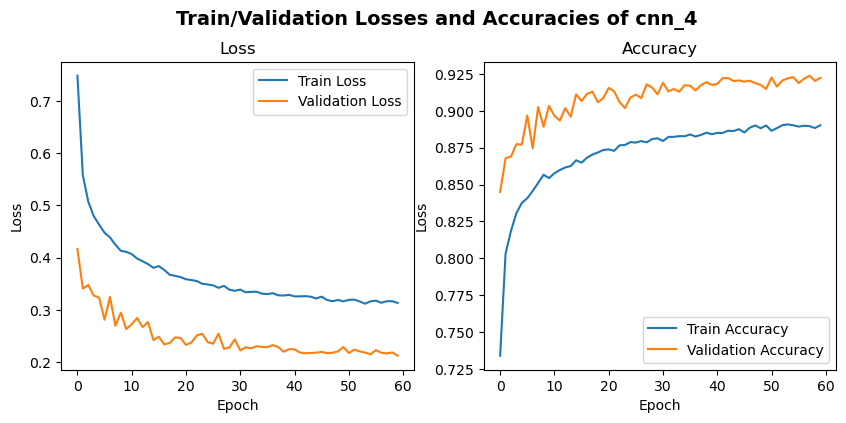

In [44]:
# Visualise the losses and accuracies
visualise_loss_accuracy(history_5.history, model_name)

In [45]:
# Store the validation accuracy and save the model
store_model_result(model_5, history_5.history, best_model, result, model_name)

The cnn_4 model has been saved.


Unfortunately, data augmentation does not improve the model performance or reduce the overfitting issue.

[Back to Contents](#back)

## 5. Model Evaluation <a id='evaluation'></a>

In [46]:
# Evaluate the models on the test set
for model in best_model:
    test_gen = datagen.flow(X_test, y_test, batch_size=32, subset='validation', seed=42)
    test_acc = best_model[model].evaluate(test_gen)[1]
    result[model]['test_acc'] = test_acc

157/157 [==============================] - 1s 3ms/step - loss: 0.2426 - acc: 0.9058


In [47]:
# Show the final accuracies
result_df = pd.DataFrame(result).transpose()

result_df

,val_acc,test_acc
basic_nn,0.8852,0.8792
cnn_1,0.9270,0.9176
cnn_2,0.9066,0.9012
cnn_3,0.9330,0.9220
cnn_4,0.9224,0.9058


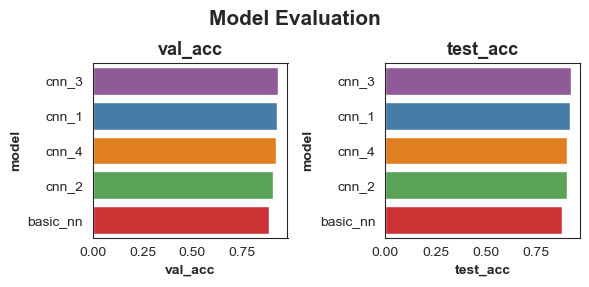

In [48]:
# Visualise the final result
plot_results = result_df.columns
nrows, ncols = 1, 2

sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3))

plt.suptitle('Model Evaluation', fontsize=15, fontweight='bold', y=0.94)

# Assign colors for models
colors = sns.color_palette('Set1')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

for i in range(ncols):
    plot_name = plot_results[i]
    plot_data = result_df[[plot_name]].sort_values(plot_name, ascending=False)

    ax = axs[i]
    sns.barplot(y=plot_data.index, x=plot_data[plot_name], palette=model_colors, hue=plot_data.index, ax=ax)        
    ax.set_title(plot_name, fontsize=13, fontweight='bold')
    ax.set_xlabel(plot_name, fontweight='bold')
    ax.set_ylabel('model', fontweight='bold')
        
plt.tight_layout()
plt.show()

The selected final model is the `CNN_3` model (no batch normalization, adjusted learning rate). It has both the highest validation and test accuracies.

Let's have a look at the confusion matrix of the final model.

In [49]:
# Get the predict probability and prediction of the final model on the test set
test_gen = datagen.flow(X_test, y_test, batch_size=32, subset='validation', seed=42)
pred_proba = best_model['cnn_3'].predict(test_gen)
y_pred = tf.argmax(pred_proba, axis=1, output_type=tf.int32)

157/157 [==============================] - 1s 4ms/step


In [50]:
# Separate the test gens into X and y
test_gen = datagen.flow(X_test, y_test, batch_size=32, subset='validation', seed=42)
X_test_final = []
y_test_final = []
for i in range(len(test_gen)):
    X_test_final.extend(test_gen[i][0])
    y_test_final.extend(test_gen[i][1])

X_test_final = tf.convert_to_tensor(X_test_final)
y_test_final = tf.convert_to_tensor(y_test_final)

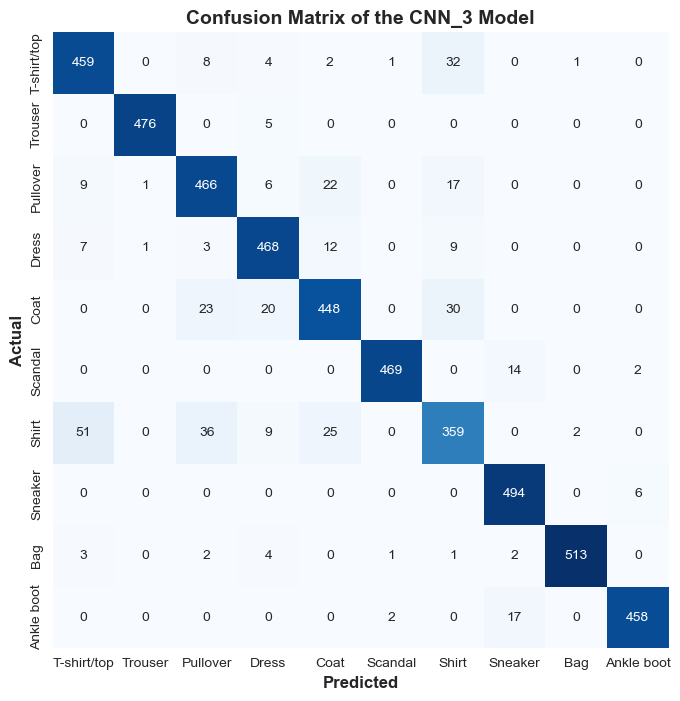

In [51]:
# Plot the confusion matrix of the final model
plt.figure(figsize=(8, 8))

cm = tf.math.confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', square=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix of the CNN_3 Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xticks(tf.range(0.5, 10, 1), class_names)
plt.yticks(tf.range(0.5, 10, 1), class_names)

plt.show()

The model has a slightly worse performance in predicting `Shirt` and `Coat`.

Finally, let's visualise some predictions from the model!

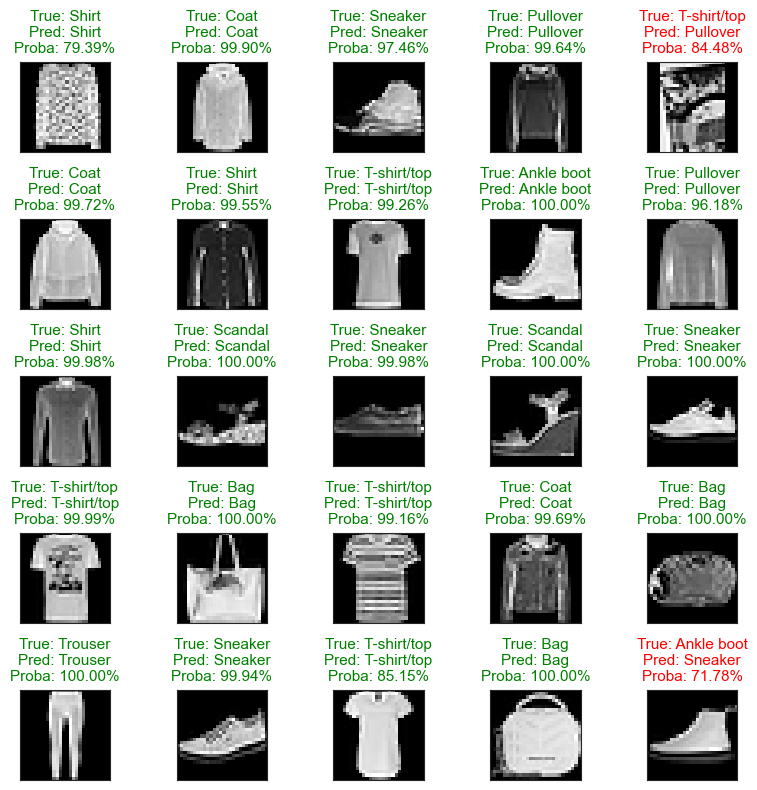

In [58]:
# Comment out the line below to get random examples
tf.random.set_seed(42)

# Set up the figure
nrows, ncols = 5, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8), sharey=True)

# Show the images and predictions
for i in range(nrows):
    for j in range(ncols):
        rand_idx = tf.random.uniform(shape=[], maxval=len(y_test_final), dtype=tf.int32)
        img = X_test_final[rand_idx]
        label = y_test_final[rand_idx]
        prediction = y_pred[rand_idx]
        proba = pred_proba[rand_idx, prediction]
        
        ax = axs[i][j]
        ax.imshow(img, cmap='gray')        
        ax.set_yticks([])
        ax.set_xticks([])

        # Green for correct prediction, red for wrong prediction
        if prediction == label:
            color = 'green'
        else:
            color = 'red'
        ax.set_title(f'True: {class_names[label]}\nPred: {class_names[prediction]}\nProba: {proba:.2%}',
                     color=color, fontsize=11)

plt.tight_layout()
plt.show()